# Question 1


## Imports


In this section we handle all types imports from installing packages, to mounting the drive to load the datasets, as well as importing the datasets themselves.

In [1]:
#install extra packages that do not come installed with google colab
%pip install scikeras

In [37]:
# mount the drive to load the dataset for question 2
from google.colab import drive
drive.mount('/content/drive')

!cd "/content/drive/MyDrive/Colab Notebooks/HW3"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import all the packages that we will use through this notebook
from tensorflow.keras import datasets, layers, models
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.image import rgb_to_grayscale
import numpy as np
from time import time
from keras.callbacks import EarlyStopping

2023-11-14 13:06:12.984580: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 13:06:13.119531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 13:06:14.519702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In the next cell, we load in the cifar10 dataset through the load_data() function from keras.dataset package.

We then normalize the data by dividing evey pixel value by 255 as that is the maximum value that a pixel could take. doing this results in pixel values that are between 0 and 1.

Finally we split the training data into training and validation data with a 80/20 spilt. resulting in 4000 images in the training set and 1000 images in the validation set.

along with normalizing the pixel values, one more thing that we can do to imporove the training time of the model would be to convert the image to grayscale. This results in converting an image of size (32x32x3) to (32x32x1).

In [3]:
# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX_full, trainY_full), (testX_full, testY_full)) = cifar10.load_data()

# scale the images to a size between 0 and 1
trainX_full = trainX_full.astype("float") / 255.0
testX = testX_full.astype("float") / 255.0
testY = testY_full

# split the training set into valudation and training set with a 80/20 split
trainX, valX, trainY, valY = train_test_split(trainX_full, trainY_full, test_size=0.2, random_state=42)

# trainX = trainX.reshape((trainX.shape[0], 3072))
# testX = testX.reshape((testX.shape[0], 3072))

[INFO] loading CIFAR-10 data...


In [5]:
#convert the images to grayscale to save time during the training process
trainX_gray = rgb2gray(trainX)
testX_gray = rgb2gray(testX)
valX_gray = rgb2gray(valX)


## Part A


Here we find 6 random samples from the training dataset and display them

You can see that each image has a height and width of 32 and is grayscaled

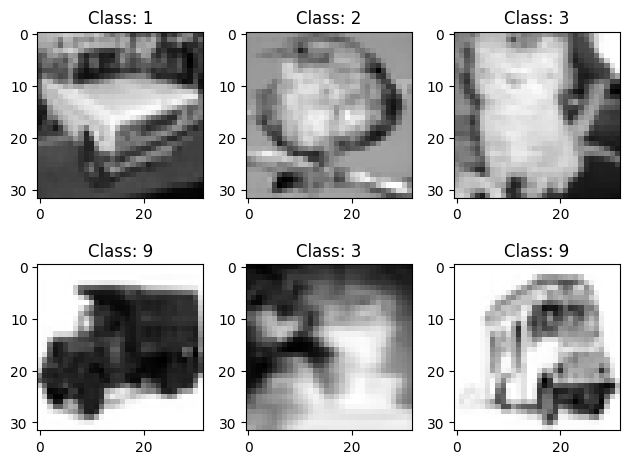

In [6]:
# Visualizing images from dataset
num_samples = 6
random_indices = np.random.choice(len(trainX), num_samples, replace=False)

for i, index in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(trainX_gray[index], cmap='gray')
    plt.title(f"Class: {trainY[index][0]}")

plt.tight_layout()
plt.show()

## Part B


Here we go through each class and find out how many images we have for each one, In this particular case we go through the training dataset before it was spilt into 2. 
We see that there are a total of 10 classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'). and each of them have 5000 samples. The testing set has another 1000 per class, leading to a total of 60000 images, where each class has 6000 images.

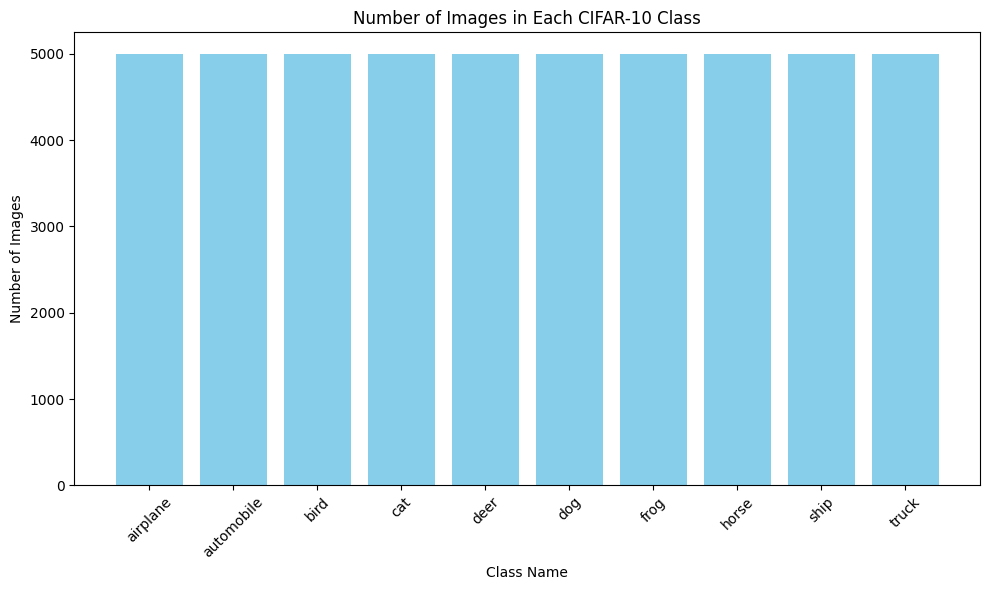

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to count the number of images in each class
class_counts = {}
for i in range(10):
    class_counts[class_names[i]] = len(trainY_full[trainY_full == i])

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each CIFAR-10 Class')
plt.xticks(rotation=45)
plt.tight_layout()

## Part C


In Part C we model and train a Feed forward Neural network with the cifar10 dataset

### part i

We need to flatten the image into 1 dimension before we feed it into the FNN, therefore we reshape the data. You can see how the shape of all the sets change after the reshaping. 

We get 1024 as it is the product of the height and width of the images. (32 * 32 = 1024)

In [6]:
print(trainX.shape)
print(testX.shape)
print(valX.shape)

# Convert the data into shape that the FNN requires
trainX = trainX_gray.reshape((trainX_gray.shape[0], -1))
testX = testX_gray.reshape((testX_gray.shape[0], -1))
valX = valX_gray.reshape((valX_gray.shape[0],-1))

print(trainX.shape)
print(testX.shape)
print(valX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1024)
(10000, 1024)
(10000, 1024)


Similarly we need to change how the labels are stored before we feed it into the FNN, in this case we convert the values into vectors using the LabelBinarizer function.

In [7]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
valY = lb.transform(valY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#### Random Search

In [ ]:
#build the model for random search with different parameters controlling different hyperparameters\
def build_model(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

In [ ]:
model2 = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25,nodes_per_layer=1024)
total_start_time = time()

# Define hyperparameters for random search
param_dist = {
    'optimizer': [Adam(lr=0.001), SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3,0.2],
    # 'activation_function': ["relu"],
    'nodes_per_layer': [1024,512]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=3, cv=5)
random_result = random_search.fit(trainX, trainY,validation_data=(valX, valY), callbacks=[early_stopping])
total_finish_time = time()

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("training time : ",total_start_time = total_finish_time)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 31s 28ms/step - loss: 2.1572 - accuracy: 0.1922 - val_loss: 2.0433 - val_accuracy: 0.2525
Epoch 2/20
1000/1000 [==============================] - 22s 22ms/step - loss: 2.0261 - accuracy: 0.2596 - val_loss: 1.9965 - val_accuracy: 0.2648
Epoch 3/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9713 - accuracy: 0.2886 - val_loss: 1.9285 - val_accuracy: 0.3075
Epoch 4/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9314 - accuracy: 0.3011 - val_loss: 1.8995 - val_accuracy: 0.3210
Epoch 5/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9029 - accuracy: 0.3090 - val_loss: 1.8691 - val_accuracy: 0.3267
Epoch 6/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8817 - accuracy: 0.3213 - val_loss: 1.8614 - val_accuracy: 0.3260
Epoch 7/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8595 - accuracy: 0.3291 - val_loss: 1.8723 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 15s 14ms/step - loss: 2.1504 - accuracy: 0.1972 - val_loss: 2.0468 - val_accuracy: 0.2532
Epoch 2/20
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0125 - accuracy: 0.2694 - val_loss: 1.9543 - val_accuracy: 0.2958
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9519 - accuracy: 0.2931 - val_loss: 1.9068 - val_accuracy: 0.3181
Epoch 4/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9162 - accuracy: 0.3091 - val_loss: 1.8905 - val_accuracy: 0.3162
Epoch 5/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8861 - accuracy: 0.3201 - val_loss: 1.8726 - val_accuracy: 0.3348
Epoch 6/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.8602 - accuracy: 0.3328 - val_loss: 1.8316 - val_accuracy: 0.3471
Epoch 7/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8421 - accuracy: 0.3407 - val_loss: 1.8454 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 17s 16ms/step - loss: 2.1463 - accuracy: 0.1986 - val_loss: 2.0554 - val_accuracy: 0.2531
Epoch 2/20
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0054 - accuracy: 0.2723 - val_loss: 1.9875 - val_accuracy: 0.2821
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9532 - accuracy: 0.2940 - val_loss: 1.9205 - val_accuracy: 0.3080
Epoch 4/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9241 - accuracy: 0.3086 - val_loss: 1.9088 - val_accuracy: 0.3044
Epoch 5/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8929 - accuracy: 0.3168 - val_loss: 1.8641 - val_accuracy: 0.3285
Epoch 6/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8691 - accuracy: 0.3281 - val_loss: 1.8569 - val_accuracy: 0.3334
Epoch 7/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8571 - accuracy: 0.3319 - val_loss: 1.8462 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 16s 15ms/step - loss: 2.1641 - accuracy: 0.1847 - val_loss: 2.0412 - val_accuracy: 0.2459
Epoch 2/20
1000/1000 [==============================] - 15s 15ms/step - loss: 2.0147 - accuracy: 0.2683 - val_loss: 1.9474 - val_accuracy: 0.2981
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9617 - accuracy: 0.2943 - val_loss: 1.9408 - val_accuracy: 0.3022
Epoch 4/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9256 - accuracy: 0.3071 - val_loss: 1.8905 - val_accuracy: 0.3207
Epoch 5/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8922 - accuracy: 0.3202 - val_loss: 1.8915 - val_accuracy: 0.3211
Epoch 6/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8728 - accuracy: 0.3274 - val_loss: 1.8727 - val_accuracy: 0.3352
Epoch 7/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8545 - accuracy: 0.3358 - val_loss: 1.8484 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 18s 17ms/step - loss: 2.1617 - accuracy: 0.1898 - val_loss: 2.0292 - val_accuracy: 0.2505
Epoch 2/20
1000/1000 [==============================] - 16s 16ms/step - loss: 2.0161 - accuracy: 0.2652 - val_loss: 1.9679 - val_accuracy: 0.2943
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9511 - accuracy: 0.2958 - val_loss: 1.8980 - val_accuracy: 0.3111
Epoch 4/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9139 - accuracy: 0.3087 - val_loss: 1.8692 - val_accuracy: 0.3286
Epoch 5/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8848 - accuracy: 0.3180 - val_loss: 1.8966 - val_accuracy: 0.3234
Epoch 6/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8606 - accuracy: 0.3269 - val_loss: 1.8516 - val_accuracy: 0.3398
Epoch 7/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8471 - accuracy: 0.3360 - val_loss: 1.8370 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 36s 35ms/step - loss: 2.1067 - accuracy: 0.2208 - val_loss: 2.0008 - val_accuracy: 0.2795
Epoch 2/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.9665 - accuracy: 0.2878 - val_loss: 1.9557 - val_accuracy: 0.2881
Epoch 3/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.9188 - accuracy: 0.3047 - val_loss: 1.9071 - val_accuracy: 0.3155
Epoch 4/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.8695 - accuracy: 0.3246 - val_loss: 1.8547 - val_accuracy: 0.3322
Epoch 5/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.8368 - accuracy: 0.3439 - val_loss: 1.8373 - val_accuracy: 0.3387
Epoch 6/20
1000/1000 [==============================] - 37s 37ms/step - loss: 1.8146 - accuracy: 0.3467 - val_loss: 1.8576 - val_accuracy: 0.3329
Epoch 7/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.7945 - accuracy: 0.3563 - val_loss: 1.8228 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 35s 33ms/step - loss: 2.1027 - accuracy: 0.2233 - val_loss: 1.9869 - val_accuracy: 0.2781
Epoch 2/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.9708 - accuracy: 0.2866 - val_loss: 1.9606 - val_accuracy: 0.2928
Epoch 3/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.9147 - accuracy: 0.3113 - val_loss: 1.9120 - val_accuracy: 0.3151
Epoch 4/20
1000/1000 [==============================] - 37s 37ms/step - loss: 1.8853 - accuracy: 0.3205 - val_loss: 1.8874 - val_accuracy: 0.3261
Epoch 5/20
1000/1000 [==============================] - 36s 36ms/step - loss: 1.8449 - accuracy: 0.3388 - val_loss: 1.8446 - val_accuracy: 0.3326
Epoch 6/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.8221 - accuracy: 0.3494 - val_loss: 1.8490 - val_accuracy: 0.3370
Epoch 7/20
1000/1000 [==============================] - 36s 36ms/step - loss: 1.8032 - accuracy: 0.3561 - val_loss: 1.8110 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 40s 39ms/step - loss: 2.1094 - accuracy: 0.2191 - val_loss: 1.9884 - val_accuracy: 0.2825
Epoch 2/20
1000/1000 [==============================] - 31s 31ms/step - loss: 1.9700 - accuracy: 0.2881 - val_loss: 1.9180 - val_accuracy: 0.3119
Epoch 3/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.9165 - accuracy: 0.3100 - val_loss: 1.8912 - val_accuracy: 0.3227
Epoch 4/20
1000/1000 [==============================] - 31s 31ms/step - loss: 1.8738 - accuracy: 0.3246 - val_loss: 1.8550 - val_accuracy: 0.3380
Epoch 5/20
1000/1000 [==============================] - 31s 31ms/step - loss: 1.8349 - accuracy: 0.3431 - val_loss: 1.8346 - val_accuracy: 0.3422
Epoch 6/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.8165 - accuracy: 0.3461 - val_loss: 1.8362 - val_accuracy: 0.3396
Epoch 7/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.7937 - accuracy: 0.3537 - val_loss: 1.8224 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 36s 35ms/step - loss: 2.1074 - accuracy: 0.2155 - val_loss: 2.0055 - val_accuracy: 0.2737
Epoch 2/20
1000/1000 [==============================] - 35s 35ms/step - loss: 1.9802 - accuracy: 0.2832 - val_loss: 1.9569 - val_accuracy: 0.2815
Epoch 3/20
1000/1000 [==============================] - 35s 35ms/step - loss: 1.9189 - accuracy: 0.3044 - val_loss: 1.9140 - val_accuracy: 0.3113
Epoch 4/20
1000/1000 [==============================] - 32s 32ms/step - loss: 1.8803 - accuracy: 0.3244 - val_loss: 1.8676 - val_accuracy: 0.3288
Epoch 5/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.8403 - accuracy: 0.3381 - val_loss: 1.8438 - val_accuracy: 0.3362
Epoch 6/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.8122 - accuracy: 0.3508 - val_loss: 1.8271 - val_accuracy: 0.3522
Epoch 7/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.7888 - accuracy: 0.3600 - val_loss: 1.7968 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 42s 40ms/step - loss: 2.1093 - accuracy: 0.2187 - val_loss: 2.0160 - val_accuracy: 0.2568
Epoch 2/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.9751 - accuracy: 0.2850 - val_loss: 1.9192 - val_accuracy: 0.3071
Epoch 3/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.9241 - accuracy: 0.3061 - val_loss: 1.8911 - val_accuracy: 0.3124
Epoch 4/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.8810 - accuracy: 0.3207 - val_loss: 1.8576 - val_accuracy: 0.3319
Epoch 5/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.8480 - accuracy: 0.3383 - val_loss: 1.8519 - val_accuracy: 0.3316
Epoch 6/20
1000/1000 [==============================] - 33s 33ms/step - loss: 1.8273 - accuracy: 0.3432 - val_loss: 1.8422 - val_accuracy: 0.3412
Epoch 7/20
1000/1000 [==============================] - 35s 35ms/step - loss: 1.7993 - accuracy: 0.3521 - val_loss: 1.8360 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1250/1250 [==============================] - 43s 33ms/step - loss: 2.0923 - accuracy: 0.2286 - val_loss: 1.9974 - val_accuracy: 0.2736
Epoch 2/20
1250/1250 [==============================] - 39s 31ms/step - loss: 1.9517 - accuracy: 0.2959 - val_loss: 1.8989 - val_accuracy: 0.3161
Epoch 3/20
1250/1250 [==============================] - 41s 33ms/step - loss: 1.8910 - accuracy: 0.3186 - val_loss: 1.8686 - val_accuracy: 0.3310
Epoch 4/20
1250/1250 [==============================] - 39s 32ms/step - loss: 1.8501 - accuracy: 0.3368 - val_loss: 1.8370 - val_accuracy: 0.3397
Epoch 5/20
1250/1250 [==============================] - 40s 32ms/step - loss: 1.8239 - accuracy: 0.3454 - val_loss: 1.8457 - val_accuracy: 0.3381
Epoch 6/20
1250/1250 [==============================] - 43s 34ms/step - loss: 1.8009 - accuracy: 0.3526 - val_loss: 1.8243 - val_accuracy: 0.3463
Epoch 7/20
1250/1250 [==============================] - 39s 31ms/step - loss: 1.7799 - accuracy: 0.3641 - val_loss: 1.8130 -

In [ ]:
model2 = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25,nodes_per_layer=1024)
total_start_time = time()
# Define hyperparameters for random search
param_dist = {
    'optimizer': [Adam(lr=0.001), SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3,0.2],
    # 'activation_function': ["relu"],
    'nodes_per_layer': [1024,512]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=3, cv=5)
random_result = random_search.fit(trainX, trainY,validation_data=(valX, valY), callbacks=[early_stopping])

total_finish_time = time()

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("training time : ",total_start_time = total_finish_time)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 15s 5ms/step - loss: 2.1575 - accuracy: 0.1927 - val_loss: 2.0460 - val_accuracy: 0.2419
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 2.0216 - accuracy: 0.2651 - val_loss: 1.9464 - val_accuracy: 0.2942
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9570 - accuracy: 0.2896 - val_loss: 1.9384 - val_accuracy: 0.2940
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9228 - accuracy: 0.3013 - val_loss: 1.8802 - val_accuracy: 0.3253
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8956 - accuracy: 0.3164 - val_loss: 1.8965 - val_accuracy: 0.3180
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8672 - accuracy: 0.3295 - val_loss: 1.8482 - val_accuracy: 0.3335
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8480 - accuracy: 0.3333 - val_loss: 1.8856 - val_accuracy

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 8s 7ms/step - loss: 2.1615 - accuracy: 0.1900 - val_loss: 2.0310 - val_accuracy: 0.2731
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0123 - accuracy: 0.2677 - val_loss: 1.9798 - val_accuracy: 0.2840
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9554 - accuracy: 0.2958 - val_loss: 1.8972 - val_accuracy: 0.3265
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9200 - accuracy: 0.3079 - val_loss: 1.8984 - val_accuracy: 0.3129
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8929 - accuracy: 0.3181 - val_loss: 1.8784 - val_accuracy: 0.3244
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8710 - accuracy: 0.3278 - val_loss: 1.8956 - val_accuracy: 0.3134
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8543 - accuracy: 0.3336 - val_loss: 1.8511 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 7s 5ms/step - loss: 2.1495 - accuracy: 0.1950 - val_loss: 2.0154 - val_accuracy: 0.2616
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 2.0089 - accuracy: 0.2674 - val_loss: 1.9709 - val_accuracy: 0.2829
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9477 - accuracy: 0.2959 - val_loss: 1.9059 - val_accuracy: 0.3178
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9073 - accuracy: 0.3132 - val_loss: 1.8935 - val_accuracy: 0.3145
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8820 - accuracy: 0.3248 - val_loss: 1.8782 - val_accuracy: 0.3283
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8516 - accuracy: 0.3357 - val_loss: 1.8348 - val_accuracy: 0.3384
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8337 - accuracy: 0.3388 - val_loss: 1.8521 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 7s 6ms/step - loss: 2.1507 - accuracy: 0.1966 - val_loss: 2.0789 - val_accuracy: 0.2397
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0113 - accuracy: 0.2678 - val_loss: 1.9624 - val_accuracy: 0.2976
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9611 - accuracy: 0.2934 - val_loss: 1.9250 - val_accuracy: 0.3097
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9264 - accuracy: 0.3089 - val_loss: 1.9184 - val_accuracy: 0.3153
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8935 - accuracy: 0.3175 - val_loss: 1.8713 - val_accuracy: 0.3286
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8593 - accuracy: 0.3356 - val_loss: 1.8883 - val_accuracy: 0.3245
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8428 - accuracy: 0.3408 - val_loss: 1.8781 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 2.1403 - accuracy: 0.2023 - val_loss: 2.0440 - val_accuracy: 0.2599
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0026 - accuracy: 0.2719 - val_loss: 1.9485 - val_accuracy: 0.2971
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9554 - accuracy: 0.2941 - val_loss: 1.9192 - val_accuracy: 0.3160
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9195 - accuracy: 0.3042 - val_loss: 1.9396 - val_accuracy: 0.2992
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8820 - accuracy: 0.3188 - val_loss: 1.8821 - val_accuracy: 0.3257
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8551 - accuracy: 0.3272 - val_loss: 1.8260 - val_accuracy: 0.3423
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.8340 - accuracy: 0.3370 - val_loss: 1.8199 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 8s 7ms/step - loss: 2.1315 - accuracy: 0.2095 - val_loss: 2.0318 - val_accuracy: 0.2690
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9902 - accuracy: 0.2789 - val_loss: 1.9419 - val_accuracy: 0.2961
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9383 - accuracy: 0.2977 - val_loss: 1.9196 - val_accuracy: 0.3132
Epoch 4/20
1000/1000 [==============================] - 7s 7ms/step - loss: 1.9000 - accuracy: 0.3163 - val_loss: 1.8598 - val_accuracy: 0.3386
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8681 - accuracy: 0.3292 - val_loss: 1.8923 - val_accuracy: 0.3231
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.8473 - accuracy: 0.3356 - val_loss: 1.8403 - val_accuracy: 0.3360
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8151 - accuracy: 0.3482 - val_loss: 1.8295 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 7s 5ms/step - loss: 2.1291 - accuracy: 0.2032 - val_loss: 1.9915 - val_accuracy: 0.2782
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9869 - accuracy: 0.2834 - val_loss: 1.9346 - val_accuracy: 0.2964
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9362 - accuracy: 0.3012 - val_loss: 1.9126 - val_accuracy: 0.3160
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9022 - accuracy: 0.3124 - val_loss: 1.8806 - val_accuracy: 0.3289
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8737 - accuracy: 0.3295 - val_loss: 1.8348 - val_accuracy: 0.3456
Epoch 6/20
1000/1000 [==============================] - 7s 7ms/step - loss: 1.8452 - accuracy: 0.3344 - val_loss: 1.8740 - val_accuracy: 0.3159
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8308 - accuracy: 0.3435 - val_loss: 1.8254 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 2.1138 - accuracy: 0.2156 - val_loss: 2.0151 - val_accuracy: 0.2651
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9937 - accuracy: 0.2726 - val_loss: 1.9469 - val_accuracy: 0.3046
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9431 - accuracy: 0.2964 - val_loss: 1.9605 - val_accuracy: 0.2899
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9113 - accuracy: 0.3089 - val_loss: 1.8984 - val_accuracy: 0.3182
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8909 - accuracy: 0.3136 - val_loss: 1.8806 - val_accuracy: 0.3204
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8645 - accuracy: 0.3266 - val_loss: 1.8799 - val_accuracy: 0.3185
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8454 - accuracy: 0.3370 - val_loss: 1.8617 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 7s 5ms/step - loss: 2.1243 - accuracy: 0.2071 - val_loss: 2.0095 - val_accuracy: 0.2776
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9813 - accuracy: 0.2828 - val_loss: 1.9140 - val_accuracy: 0.3145
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9355 - accuracy: 0.2988 - val_loss: 1.8875 - val_accuracy: 0.3247
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8969 - accuracy: 0.3157 - val_loss: 1.8648 - val_accuracy: 0.3304
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8668 - accuracy: 0.3289 - val_loss: 1.8416 - val_accuracy: 0.3414
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.8395 - accuracy: 0.3413 - val_loss: 1.8260 - val_accuracy: 0.3465
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8138 - accuracy: 0.3468 - val_loss: 1.8548 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 8s 6ms/step - loss: 2.1289 - accuracy: 0.2026 - val_loss: 2.0519 - val_accuracy: 0.2437
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0069 - accuracy: 0.2656 - val_loss: 1.9512 - val_accuracy: 0.2988
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9492 - accuracy: 0.2937 - val_loss: 1.9580 - val_accuracy: 0.2937
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9083 - accuracy: 0.3088 - val_loss: 1.8809 - val_accuracy: 0.3161
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8742 - accuracy: 0.3258 - val_loss: 1.8553 - val_accuracy: 0.3431
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.8481 - accuracy: 0.3347 - val_loss: 1.8418 - val_accuracy: 0.3408
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8250 - accuracy: 0.3428 - val_loss: 1.8433 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 8s 7ms/step - loss: 2.1321 - accuracy: 0.2033 - val_loss: 2.0079 - val_accuracy: 0.2530
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9984 - accuracy: 0.2721 - val_loss: 1.9517 - val_accuracy: 0.2877
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9377 - accuracy: 0.2974 - val_loss: 1.9484 - val_accuracy: 0.2980
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9024 - accuracy: 0.3135 - val_loss: 1.8822 - val_accuracy: 0.3312
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8746 - accuracy: 0.3248 - val_loss: 1.8679 - val_accuracy: 0.3263
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8488 - accuracy: 0.3377 - val_loss: 1.8794 - val_accuracy: 0.3320
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8295 - accuracy: 0.3440 - val_loss: 1.8220 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 2.1298 - accuracy: 0.2094 - val_loss: 2.0373 - val_accuracy: 0.2561
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9935 - accuracy: 0.2765 - val_loss: 1.9486 - val_accuracy: 0.2923
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9437 - accuracy: 0.3000 - val_loss: 1.9352 - val_accuracy: 0.3095
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9087 - accuracy: 0.3128 - val_loss: 1.8786 - val_accuracy: 0.3300
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8797 - accuracy: 0.3243 - val_loss: 1.8662 - val_accuracy: 0.3316
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8585 - accuracy: 0.3335 - val_loss: 1.8474 - val_accuracy: 0.3377
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8407 - accuracy: 0.3402 - val_loss: 1.8393 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 7s 5ms/step - loss: 2.1253 - accuracy: 0.2155 - val_loss: 2.0538 - val_accuracy: 0.2501
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9847 - accuracy: 0.2823 - val_loss: 1.9523 - val_accuracy: 0.2880
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9307 - accuracy: 0.3029 - val_loss: 1.9010 - val_accuracy: 0.3200
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9003 - accuracy: 0.3167 - val_loss: 1.8759 - val_accuracy: 0.3262
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8638 - accuracy: 0.3310 - val_loss: 1.8444 - val_accuracy: 0.3422
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8420 - accuracy: 0.3407 - val_loss: 1.8232 - val_accuracy: 0.3495
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.8251 - accuracy: 0.3451 - val_loss: 1.8490 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 9s 7ms/step - loss: 2.1339 - accuracy: 0.2015 - val_loss: 2.0254 - val_accuracy: 0.2602
Epoch 2/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9912 - accuracy: 0.2752 - val_loss: 1.9297 - val_accuracy: 0.3064
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9343 - accuracy: 0.3026 - val_loss: 1.8905 - val_accuracy: 0.3178
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.9022 - accuracy: 0.3122 - val_loss: 1.8910 - val_accuracy: 0.3247
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8746 - accuracy: 0.3233 - val_loss: 1.8744 - val_accuracy: 0.3243
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8535 - accuracy: 0.3313 - val_loss: 1.8769 - val_accuracy: 0.3233
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8447 - accuracy: 0.3335 - val_loss: 1.8411 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 6s 5ms/step - loss: 2.1381 - accuracy: 0.2048 - val_loss: 2.0310 - val_accuracy: 0.2616
Epoch 2/20
1000/1000 [==============================] - 7s 7ms/step - loss: 1.9920 - accuracy: 0.2766 - val_loss: 1.9802 - val_accuracy: 0.2823
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9470 - accuracy: 0.2979 - val_loss: 1.9207 - val_accuracy: 0.3070
Epoch 4/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.9116 - accuracy: 0.3094 - val_loss: 1.9156 - val_accuracy: 0.3049
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.8807 - accuracy: 0.3232 - val_loss: 1.8658 - val_accuracy: 0.3281
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8585 - accuracy: 0.3332 - val_loss: 1.8582 - val_accuracy: 0.3334
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.8291 - accuracy: 0.3415 - val_loss: 1.8365 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1250/1250 [==============================] - 8s 5ms/step - loss: 2.1078 - accuracy: 0.2155 - val_loss: 2.0043 - val_accuracy: 0.2811
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9723 - accuracy: 0.2844 - val_loss: 1.9342 - val_accuracy: 0.3059
Epoch 3/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9155 - accuracy: 0.3098 - val_loss: 1.9152 - val_accuracy: 0.3185
Epoch 4/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8794 - accuracy: 0.3234 - val_loss: 1.8300 - val_accuracy: 0.3441
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8535 - accuracy: 0.3328 - val_loss: 1.8451 - val_accuracy: 0.3398
Epoch 6/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8301 - accuracy: 0.3417 - val_loss: 1.8175 - val_accuracy: 0.3463
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8111 - accuracy: 0.3489 - val_loss: 1.7940 - val_accuracy:

#### 3 models

In [8]:
# define a model 1
def build_model_1(optimizer='adam', dropout_rate=0.25,activation_function='relu'):
  model = Sequential()
  model.add(Dense(512, input_shape=(1024,), activation=activation_function))
  model.add(Dense(256, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

# Train the model 1 with validation
total_start_time = time()
model = build_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])
total_finish_time = time()

2023-11-14 13:06:39.828912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 13:06:40.065082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 13:06:40.065143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 13:06:40.070787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 13:06:40.070884: I tensorflow/compile

Epoch 1/50


2023-11-14 13:06:49.240302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 13:06:49.313634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7ce76aa380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 13:06:49.313691: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-14 13:06:49.478100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 13:06:52.294740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-14 13:06:52.781966: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 13:

1250/1250 [==============================] - 19s 6ms/step - loss: 2.1261 - accuracy: 0.2083 - val_loss: 2.0295 - val_accuracy: 0.2698
Epoch 2/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9805 - accuracy: 0.2842 - val_loss: 1.9210 - val_accuracy: 0.3143
Epoch 3/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9273 - accuracy: 0.3044 - val_loss: 1.8960 - val_accuracy: 0.3215
Epoch 4/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8876 - accuracy: 0.3201 - val_loss: 1.8669 - val_accuracy: 0.3303
Epoch 5/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8615 - accuracy: 0.3312 - val_loss: 1.8771 - val_accuracy: 0.3311
Epoch 6/50
1250/1250 [==============================] - 8s 7ms/step - loss: 1.8405 - accuracy: 0.3412 - val_loss: 1.8573 - val_accuracy: 0.3344
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8186 - accuracy: 0.3490 - val_loss: 1.8109 - val_accuracy: 0.3556
Ep

model 1 summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10) 

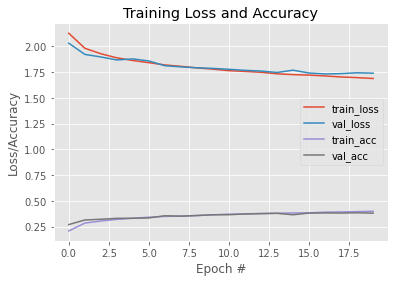

In [9]:
print("model 1 summary")
model.summary()
val_loss_1, val_acc_1 = model.evaluate(valX, valY, verbose=0)
print(f"Model 1 - Validation Accuracy: {val_acc_1}, Validation Loss: {val_loss_1}")
print(f"Model 1 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [19]:
# define model 2
def build_model_2(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.25,activation_function='relu'):
  model = Sequential()
  model.add(Dense(1024, input_shape=(1024,), activation=activation_function))
  model.add(Dense(512, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(256, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(128, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

# train model 2 with validation
total_start_time = time()
model = build_model_2()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])

total_finish_time = time()

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0803 - accuracy: 0.2368 - val_loss: 1.9773 - val_accuracy: 0.2835
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9562 - accuracy: 0.2921 - val_loss: 1.9032 - val_accuracy: 0.3208
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8923 - accuracy: 0.3183 - val_loss: 1.8757 - val_accuracy: 0.3268
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8506 - accuracy: 0.3326 - val_loss: 1.8107 - val_accuracy: 0.3586
Epoch 5/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8138 - accuracy: 0.3485 - val_loss: 1.7929 - val_accuracy: 0.3562
Epoch 6/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7825 - accuracy: 0.3623 - val_loss: 1.7767 - val_accuracy: 0.3642
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7518 - accuracy: 0.3718 - val_loss: 1.7565 - val_accuracy:

In [ ]:
print("model 2 summary")
model.summary()
val_loss_1, val_acc_1 = model.evaluate(valX, valY, verbose=0)
print(f"Model 2 - Validation Accuracy: {val_acc_1}, Validation Loss: {val_loss_1}")
print(f"Model 2 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [20]:
# define model 3
def build_model_3(optimizer='adam', dropout_rate=0.25,activation_function='relu'):
  model = Sequential()
  model.add(Dense(32, input_shape=(1024,), activation=activation_function))
  model.add(Dense(64, activation=activation_function))
  model.add(Dense(64, activation=activation_function))
  model.add(Dense(32, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

# train model 3 with validation
total_start_time = time()
model = build_model_3()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])

total_finish_time = time()

Epoch 1/50
1250/1250 [==============================] - 8s 5ms/step - loss: 2.0551 - accuracy: 0.2463 - val_loss: 1.9624 - val_accuracy: 0.2954
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9161 - accuracy: 0.3099 - val_loss: 1.9666 - val_accuracy: 0.2931
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8544 - accuracy: 0.3340 - val_loss: 1.8789 - val_accuracy: 0.3328
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8073 - accuracy: 0.3498 - val_loss: 1.7946 - val_accuracy: 0.3641
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7675 - accuracy: 0.3693 - val_loss: 1.8209 - val_accuracy: 0.3480
Epoch 6/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7341 - accuracy: 0.3788 - val_loss: 1.7796 - val_accuracy: 0.3607
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7046 - accuracy: 0.3905 - val_loss: 1.7612 - val_accuracy:

In [ ]:
print("model 3 summary")
model.summary()
val_loss_1, val_acc_1 = model.evaluate(valX, valY, verbose=0)
print(f"Model 3 - Validation Accuracy: {val_acc_1}, Validation Loss: {val_loss_1}")
print(f"Model 3 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### part ii

In this part we take the best model from the previous part and run it with the test dataset to get the final test accuracy

In [22]:
# run the best model
total_start_time = time()
model_final = build_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model_final.fit(trainX, trainY, validation_data=(testX, testY),epochs=50, batch_size=32, callbacks=[early_stopping])
total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)

Epoch 1/50
1250/1250 [==============================] - 13s 8ms/step - loss: 2.1309 - accuracy: 0.2076 - val_loss: 2.0038 - val_accuracy: 0.2851
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9783 - accuracy: 0.2853 - val_loss: 1.9112 - val_accuracy: 0.3076
Epoch 3/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9196 - accuracy: 0.3087 - val_loss: 1.8751 - val_accuracy: 0.3302
Epoch 4/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8884 - accuracy: 0.3197 - val_loss: 1.8466 - val_accuracy: 0.3362
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8588 - accuracy: 0.3304 - val_loss: 1.8300 - val_accuracy: 0.3564
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8313 - accuracy: 0.3417 - val_loss: 1.8065 - val_accuracy: 0.3573
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8182 - accuracy: 0.3481 - val_loss: 1.8066 - val_accuracy

In [23]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

model.summary()

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.57      0.22      0.32      1000
  automobile       0.46      0.52      0.49      1000
        bird       0.29      0.39      0.34      1000
         cat       0.23      0.36      0.28      1000
        deer       0.28      0.32      0.30      1000
         dog       0.41      0.34      0.37      1000
        frog       0.41      0.39      0.40      1000
       horse       0.48      0.49      0.49      1000
        ship       0.56      0.40      0.46      1000
       truck       0.46      0.42      0.44      1000

    accuracy                           0.39     10000
   macro avg       0.42      0.39      0.39     10000
weighted avg       0.42      0.39      0.39     10000

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

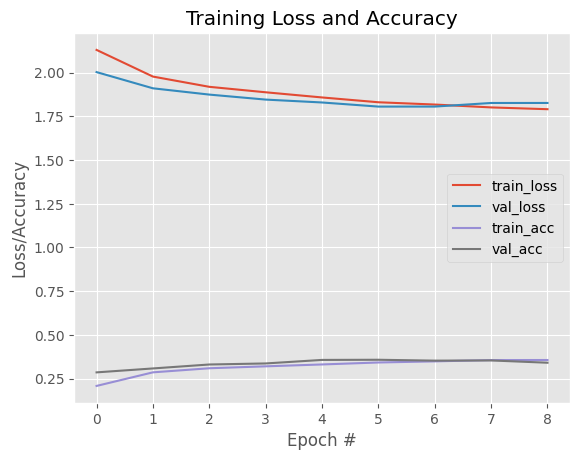

In [25]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Train')
plt.plot(H.history['val_loss'], label='Validation')
plt.title('Model 5 - Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Train')
plt.plot(H.history['val_accuracy'], label='Validation')
plt.title('Model 5 - Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We then plot a confusion matrix for the model. The confusion matrix is a method to test how good a model is at predicting. In this case the confusion matrix is a 10 x 10 table, where each column represents a predicted class and each row represents the true value of the class.

We can read the confusion matrix by checking the values in an element, and the column represent what the model predicted and the row is what the actual value is. for example a cat has been predicted as a horse ___ number of times. for convience the matrix has been heat-color coded, which means that the darker the color is the larger the number is in that cell. 

We can find the following metrics from the confusion matrix
- [TP] the elemnent where the true and predicted class are the same
- [FN] sum of all the elements in the same column besides the one which true and predicted are the same
- [FP] sum of all the elements in the same row besides the one which ture and predicted are the same
- [TN] sum of all other elements

from these values you can calculate other metrics such as precision, recall and f1 score for every class.

Some classes are more likely to be mistaken for one another as the model find similar features in each of them. 
Since every class in the test data has the same number of elements, the numbers on the matrix is a good show of how accurate the model was at predicting that certain class. 

(10000,)
(10000,)


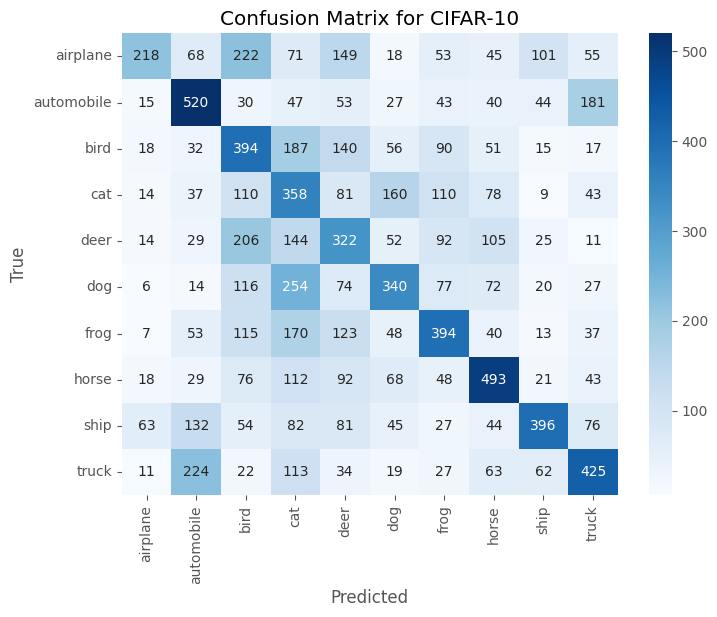

In [26]:
# Make predictions on the test set
y_pred = predictions
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

print(y_pred_classes.shape)
print(y_true.shape)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()

## Part D


Here we re-initialize the cifar10 dataset. This is because of the way FNN and CNN require different types of inputs, FNN requires the image to be flattened before feeding to the network while CNN requires them to be in 2d format, so that it can convolve on that layer. One way to mitigate this would be to add a flatten layer as the first layer in the FNN. 

We also change the way that we reprsent the labels. Here we perform one-hot encoding to the labels using the to_categorical() function, which converts a class vector (integers) to binary class matrix.

### part i

In [27]:
# reload the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# perform one-hot encoding for the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels  = to_categorical(val_labels)

#convert the images to grayscale to save time during training
train_images = rgb_to_grayscale(train_images)
test_images = rgb_to_grayscale(test_images)
val_images = rgb_to_grayscale(val_images)

print(train_images.shape)
print(test_labels.shape)

(40000, 32, 32, 1)
(10000, 10)


#### RandomSearch

In [ ]:
# define a model for randomsearch with each parameter controlling a differnet hyperparameter
def create_model(optimizer='adam', dropout_rate=0.25,activation_function="relu"):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(val_images, val_labels), verbose=1)
  return model

In [ ]:
model2 = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25,activation_function="relu")

# Define hyperparameters for random search
param_dist = {
    'optimizer': [Adam(lr=0.001), SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3, 0.5,0.2],
    "activation_function":["relu","elu"]
}

total_start_time = time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=3, cv=5)
random_result = random_search.fit(train_images, train_labels,validation_data=(val_images, val_labels), callbacks=[early_stopping])

total_finish_time = time()
print("training time : ",total_start_time = total_finish_time)

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 31s 10ms/step - loss: 1.7250 - accuracy: 0.3603 - val_loss: 1.2773 - val_accuracy: 0.5366
Epoch 2/20
1000/1000 [==============================] - 7s 7ms/step - loss: 1.2544 - accuracy: 0.5467 - val_loss: 1.0696 - val_accuracy: 0.6167
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.0382 - accuracy: 0.6337 - val_loss: 0.9158 - val_accuracy: 0.6753
Epoch 4/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9056 - accuracy: 0.6854 - val_loss: 0.8092 - val_accuracy: 0.7130
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.8240 - accuracy: 0.7130 - val_loss: 0.8204 - val_accuracy: 0.7104
Epoch 6/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7546 - accuracy: 0.7351 - val_loss: 0.7224 - val_accuracy: 0.7477
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6982 - accuracy: 0.7538 - val_loss: 0.7084 - val_accurac

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 10s 8ms/step - loss: 1.7251 - accuracy: 0.3641 - val_loss: 1.3831 - val_accuracy: 0.4911
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.2673 - accuracy: 0.5444 - val_loss: 1.0439 - val_accuracy: 0.6315
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0477 - accuracy: 0.6293 - val_loss: 0.9756 - val_accuracy: 0.6543
Epoch 4/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.9197 - accuracy: 0.6755 - val_loss: 0.8419 - val_accuracy: 0.7001
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8327 - accuracy: 0.7076 - val_loss: 0.7808 - val_accuracy: 0.7269
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7615 - accuracy: 0.7348 - val_loss: 0.7935 - val_accuracy: 0.7230
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7138 - accuracy: 0.7495 - val_loss: 0.7684 - val_accuracy

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 12s 9ms/step - loss: 1.6690 - accuracy: 0.3838 - val_loss: 1.2810 - val_accuracy: 0.5383
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.2362 - accuracy: 0.5574 - val_loss: 1.0749 - val_accuracy: 0.6157
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0146 - accuracy: 0.6421 - val_loss: 0.8884 - val_accuracy: 0.6821
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8837 - accuracy: 0.6892 - val_loss: 0.7983 - val_accuracy: 0.7195
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7918 - accuracy: 0.7220 - val_loss: 0.7388 - val_accuracy: 0.7382
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7379 - accuracy: 0.7422 - val_loss: 0.7510 - val_accuracy: 0.7337
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6819 - accuracy: 0.7612 - val_loss: 0.8188 - val_accuracy

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 12s 9ms/step - loss: 1.7291 - accuracy: 0.3557 - val_loss: 1.3457 - val_accuracy: 0.5145
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.2927 - accuracy: 0.5367 - val_loss: 1.0391 - val_accuracy: 0.6337
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0617 - accuracy: 0.6224 - val_loss: 0.9383 - val_accuracy: 0.6748
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9372 - accuracy: 0.6699 - val_loss: 0.8381 - val_accuracy: 0.7106
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8520 - accuracy: 0.7016 - val_loss: 0.7925 - val_accuracy: 0.7240
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7875 - accuracy: 0.7236 - val_loss: 0.7978 - val_accuracy: 0.7251
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7259 - accuracy: 0.7458 - val_loss: 0.7672 - val_accuracy

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 12s 10ms/step - loss: 1.6954 - accuracy: 0.3722 - val_loss: 1.3564 - val_accuracy: 0.5012
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 1.2314 - accuracy: 0.5575 - val_loss: 1.0832 - val_accuracy: 0.6047
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 1.0316 - accuracy: 0.6344 - val_loss: 0.8902 - val_accuracy: 0.6808
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9117 - accuracy: 0.6758 - val_loss: 0.8160 - val_accuracy: 0.7123
Epoch 5/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.8292 - accuracy: 0.7096 - val_loss: 0.7709 - val_accuracy: 0.7205
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7613 - accuracy: 0.7338 - val_loss: 0.7338 - val_accuracy: 0.7439
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7182 - accuracy: 0.7456 - val_loss: 0.6924 - val_acc

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
1000/1000 [==============================] - 13s 9ms/step - loss: 1.7158 - accuracy: 0.3606 - val_loss: 1.3111 - val_accuracy: 0.5192
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.2696 - accuracy: 0.5397 - val_loss: 1.0685 - val_accuracy: 0.6178
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 1.0628 - accuracy: 0.6247 - val_loss: 0.9018 - val_accuracy: 0.6819
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.9375 - accuracy: 0.6703 - val_loss: 0.8442 - val_accuracy: 0.6992
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8450 - accuracy: 0.7045 - val_loss: 0.8155 - val_accuracy: 0.7126
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7844 - accuracy: 0.7252 - val_loss: 0.7675 - val_accuracy: 0.7324
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7300 - accuracy: 0.7442 - val_loss: 0.7163 - val_accura

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


#### 3 models with different hyper parameters

In [28]:
# define model 1
def create_model_1(optimizer='adam', dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# train the model with validation
total_start_time = time()
model = create_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])

total_finish_time = time()

Epoch 1/50
625/625 [==============================] - 15s 12ms/step - loss: 1.9379 - accuracy: 0.2840 - val_loss: 1.5608 - val_accuracy: 0.4340
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.4813 - accuracy: 0.4672 - val_loss: 1.2131 - val_accuracy: 0.5706
Epoch 3/50
625/625 [==============================] - 7s 10ms/step - loss: 1.2303 - accuracy: 0.5664 - val_loss: 1.1041 - val_accuracy: 0.6234
Epoch 4/50
625/625 [==============================] - 7s 10ms/step - loss: 1.0729 - accuracy: 0.6252 - val_loss: 0.9116 - val_accuracy: 0.6887
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.9708 - accuracy: 0.6621 - val_loss: 0.8690 - val_accuracy: 0.7042
Epoch 6/50
625/625 [==============================] - 7s 10ms/step - loss: 0.8765 - accuracy: 0.6944 - val_loss: 0.7686 - val_accuracy: 0.7448
Epoch 7/50
625/625 [==============================] - 7s 11ms/step - loss: 0.8179 - accuracy: 0.7152 - val_loss: 0.7940 - val_accuracy: 0.7297

In [ ]:
print("model 1 summary")
model.summary()
val_loss_1, val_acc_1 = model.evaluate(valX, valY, verbose=0)
print(f"Model 1 - Validation Accuracy: {val_acc_1}, Validation Loss: {val_loss_1}")
print(f"Model 1 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [29]:
# define model 2
def create_model_2(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# train the model with validation
total_start_time = time()
model = create_model_2()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])
total_finish_time = time()

Epoch 1/50
625/625 [==============================] - 9s 12ms/step - loss: 1.7647 - accuracy: 0.3573 - val_loss: 1.4454 - val_accuracy: 0.4953
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.2414 - accuracy: 0.5635 - val_loss: 1.1373 - val_accuracy: 0.6044
Epoch 3/50
625/625 [==============================] - 6s 9ms/step - loss: 0.9729 - accuracy: 0.6611 - val_loss: 0.9682 - val_accuracy: 0.6680
Epoch 4/50
625/625 [==============================] - 8s 12ms/step - loss: 0.8131 - accuracy: 0.7165 - val_loss: 0.9446 - val_accuracy: 0.6774
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.6787 - accuracy: 0.7608 - val_loss: 0.8184 - val_accuracy: 0.7221
Epoch 6/50
625/625 [==============================] - 7s 11ms/step - loss: 0.5660 - accuracy: 0.8012 - val_loss: 0.8377 - val_accuracy: 0.7239
Epoch 7/50
625/625 [==============================] - 6s 10ms/step - loss: 0.4731 - accuracy: 0.8335 - val_loss: 0.8860 - val_accuracy: 0.7236
E

In [ ]:
print("model 2 summary")
model.summary()
val_loss_2, val_acc_2 = model.evaluate(valX, valY, verbose=0)
print(f"Model 2 - Validation Accuracy: {val_acc_2}, Validation Loss: {val_loss_2}")
print(f"Model 2 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [30]:
# define model 3
def create_model_3(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.3):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='elu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# train model 3 with validation
total_start_time = time()
model = create_model_3()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])
total_finish_time = time()

Epoch 1/50
625/625 [==============================] - 11s 14ms/step - loss: 2.5235 - accuracy: 0.0978 - val_loss: 2.4100 - val_accuracy: 0.1017
Epoch 2/50
625/625 [==============================] - 7s 12ms/step - loss: 2.3725 - accuracy: 0.0998 - val_loss: 2.3802 - val_accuracy: 0.0933
Epoch 3/50
625/625 [==============================] - 9s 14ms/step - loss: 2.3785 - accuracy: 0.0997 - val_loss: 2.3812 - val_accuracy: 0.0979
Epoch 4/50
625/625 [==============================] - 7s 11ms/step - loss: 2.3666 - accuracy: 0.0994 - val_loss: 2.3395 - val_accuracy: 0.0979
Epoch 5/50
625/625 [==============================] - 9s 14ms/step - loss: 2.3639 - accuracy: 0.1016 - val_loss: 2.3390 - val_accuracy: 0.0979
Epoch 6/50
625/625 [==============================] - 7s 11ms/step - loss: 2.3699 - accuracy: 0.1037 - val_loss: 2.3531 - val_accuracy: 0.1040
Epoch 7/50
625/625 [==============================] - 10s 16ms/step - loss: 2.3736 - accuracy: 0.0991 - val_loss: 2.3774 - val_accuracy: 0.09

In [ ]:
print("model 3 summary")
model.summary()
val_loss_3, val_acc_3 = model.evaluate(valX, valY, verbose=0)
print(f"Model 3 - Validation Accuracy: {val_acc_3}, Validation Loss: {val_loss_3}")
print(f"Model 3 - Number of Parameters: {model.count_params()}")
print(f"training time : {total_finish_time - total_start_time}")

# Plot the training history
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### part ii

In this part we take the best model from the previous part and run it with the test dataset to get the final test accuracy

In [33]:
# run the best model to find accuracy with test samples
total_start_time = time()
model = create_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(test_images, test_labels), verbose=1, callbacks=[early_stopping])

model.summary()
total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)



Epoch 1/50
625/625 [==============================] - 13s 13ms/step - loss: 1.9275 - accuracy: 0.2886 - val_loss: 1.6092 - val_accuracy: 0.4216
Epoch 2/50
625/625 [==============================] - 7s 11ms/step - loss: 1.4628 - accuracy: 0.4776 - val_loss: 1.2181 - val_accuracy: 0.5805
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 1.2060 - accuracy: 0.5800 - val_loss: 1.0274 - val_accuracy: 0.6448
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 1.0505 - accuracy: 0.6362 - val_loss: 0.9039 - val_accuracy: 0.6841
Epoch 5/50
625/625 [==============================] - 7s 11ms/step - loss: 0.9356 - accuracy: 0.6772 - val_loss: 0.8497 - val_accuracy: 0.7084
Epoch 6/50
625/625 [==============================] - 6s 10ms/step - loss: 0.8640 - accuracy: 0.7017 - val_loss: 0.8154 - val_accuracy: 0.7146
Epoch 7/50
625/625 [==============================] - 6s 10ms/step - loss: 0.8088 - accuracy: 0.7211 - val_loss: 0.7743 - val_accuracy: 0.7369

313/313 - 1s - loss: 0.6782 - accuracy: 0.7791 - 1s/epoch - 3ms/step
0.7791000008583069


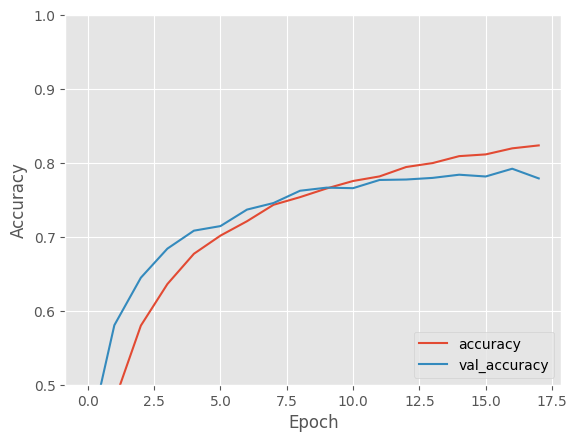

In [34]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Train')
plt.plot(H.history['val_loss'], label='Validation')
plt.title('Model 5 - Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Train')
plt.plot(H.history['val_accuracy'], label='Validation')
plt.title('Model 5 - Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Part E

In [7]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import accuracy_score

# Split data into training and validation
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# perform one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val  = to_categorical(y_val)

# convert to grayscale
X_train = rgb_to_grayscale(X_train)
X_test = rgb_to_grayscale(X_test)
X_val = rgb_to_grayscale(X_val)

# Function to create model
def create_model(params):
        model = Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(params['dropout_rate']))
        model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(params['dropout_rate']))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(params['dropout_rate']))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(layers.Dropout(params['dropout_rate']))
        model.add(layers.Dense(10, activation='softmax'))
        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

# Objective function to minimize (or maximize if using loss as the objective)
def objective(params):
    model = create_model(params)


    # X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
    # X_val = np.expand_dims(X_val, axis=-1)

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

    return {'loss': -val_accuracy, 'status': STATUS_OK}

# Hyperparameter search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
}

# Trials object to store results
trials = Trials()

# Run Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

total_start_time = time()
# Train the best model on the full training set
best_model = create_model(best_params)
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)

# Evaluate the best model on the test set
test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy:", test_accuracy)



782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 3s 3ms/step

782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 3s 3ms/step

782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 3s 4ms/step

782/782 [==============================] - 2s 3ms/step

782/782 [==============================] - 3s 3ms/step

100%|██████████| 10/10 [10:16<00:00, 61.69s/trial, best loss: -0.34416]
Best Hyperparameters: {'dropout_rate': 0.21690928230453, 'learning_rate': 0.003066083622218923}
Test Accuracy: 0.3497999906539917


## Part F

In [ ]:
from keras.applications import EfficientNetB0

# Load CIFAR-10 data
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()

# split the dataset into training and validation with a 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# perform one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


In [ ]:
def build_model1():
  model = Sequential()
  model.add(base_model)
  # add the extra layers to tune it to cifar10
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

total_start_time = time()
model = build_model1()
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)


Epoch 1/5
1250/1250 [==============================] - 92s 48ms/step - loss: 1.1439 - accuracy: 0.6195 - val_loss: 0.7524 - val_accuracy: 0.7467
Epoch 2/5
1250/1250 [==============================] - 62s 49ms/step - loss: 0.7755 - accuracy: 0.7472 - val_loss: 0.6838 - val_accuracy: 0.7737
Epoch 3/5
1250/1250 [==============================] - 61s 49ms/step - loss: 0.6701 - accuracy: 0.7806 - val_loss: 0.6209 - val_accuracy: 0.7945
Epoch 4/5
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5951 - accuracy: 0.8046 - val_loss: 0.6096 - val_accuracy: 0.7999
Epoch 5/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.5350 - accuracy: 0.8282 - val_loss: 0.5632 - val_accuracy: 0.8128


In [ ]:
def build_model1():
  model = Sequential()
  model.add(base_model)
  # add the extra layers to tune it to cifar10
  model.add(GlobalAveragePooling2D())
  model.add(Dense(512, activation='tanh'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

total_start_time = time()

model2 = build_model1()
model2.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)

Epoch 1/5
1250/1250 [==============================] - 95s 50ms/step - loss: 0.5594 - accuracy: 0.8257 - val_loss: 0.5519 - val_accuracy: 0.8176
Epoch 2/5
1250/1250 [==============================] - 57s 46ms/step - loss: 0.4516 - accuracy: 0.8540 - val_loss: 0.5205 - val_accuracy: 0.8275
Epoch 3/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.4051 - accuracy: 0.8684 - val_loss: 0.6002 - val_accuracy: 0.8105
Epoch 4/5
1250/1250 [==============================] - 61s 49ms/step - loss: 0.3836 - accuracy: 0.8732 - val_loss: 0.5402 - val_accuracy: 0.8322
Epoch 5/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.3457 - accuracy: 0.8871 - val_loss: 0.5964 - val_accuracy: 0.8161


In [ ]:
def build_model1():
  model = Sequential()
  model.add(base_model)
  # add the extra layers to tune it to cifar10
  model.add(GlobalAveragePooling2D())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  # Compile the model
  model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

total_start_time = time()

model3 = build_model1()
model3.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
total_finish_time = time()
print("training time : ",total_finish_time - total_start_time)

Epoch 1/5
1250/1250 [==============================] - 77s 45ms/step - loss: 0.3356 - accuracy: 0.8968 - val_loss: 0.5471 - val_accuracy: 0.8279
Epoch 2/5
1250/1250 [==============================] - 57s 46ms/step - loss: 0.2567 - accuracy: 0.9179 - val_loss: 0.5569 - val_accuracy: 0.8279
Epoch 3/5
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2263 - accuracy: 0.9270 - val_loss: 0.5314 - val_accuracy: 0.8394
Epoch 4/5
1250/1250 [==============================] - 62s 49ms/step - loss: 0.2054 - accuracy: 0.9339 - val_loss: 0.5608 - val_accuracy: 0.8358
Epoch 5/5
1250/1250 [==============================] - 61s 49ms/step - loss: 0.1906 - accuracy: 0.9405 - val_loss: 0.5619 - val_accuracy: 0.8408


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Question 2

## Imports

In [35]:
# import the necessary packages
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
# import the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HW3/datasets/Admission.csv")
print(df.columns)

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')


In [40]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Part A

In [41]:
# convert the labels to 1 and 0 depending on the mean size
mean_chance_of_admit = df["Chance of Admit "].mean()
print(mean_chance_of_admit)
df["Admission"] = (df["Chance of Admit "] > mean_chance_of_admit).astype(int)
print(df["Admission"])

0.72435
0      1
1      1
2      0
3      1
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Admission, Length: 400, dtype: int64


## Part B

In [42]:
# Initialize all the differnet types of SVMs
# standardize the values of the dataset
svm_linear = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
linear_svc =  make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
svm_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='rbf'))
svm_poly = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='poly'))

## Part C

In [43]:
# define all the feature combinations
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

# loop through all the feautres and
for features in feature_combinations:
    X = df[features]
    y = df["Admission"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM models with the selected features
    svm_linear.fit(X_train, y_train)
    linear_svc.fit(X_train, y_train)
    svm_rbf.fit(X_train, y_train)
    svm_poly.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

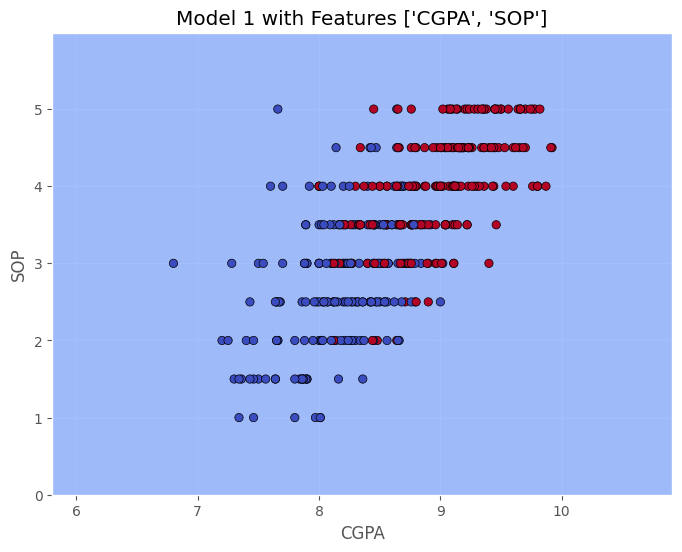

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

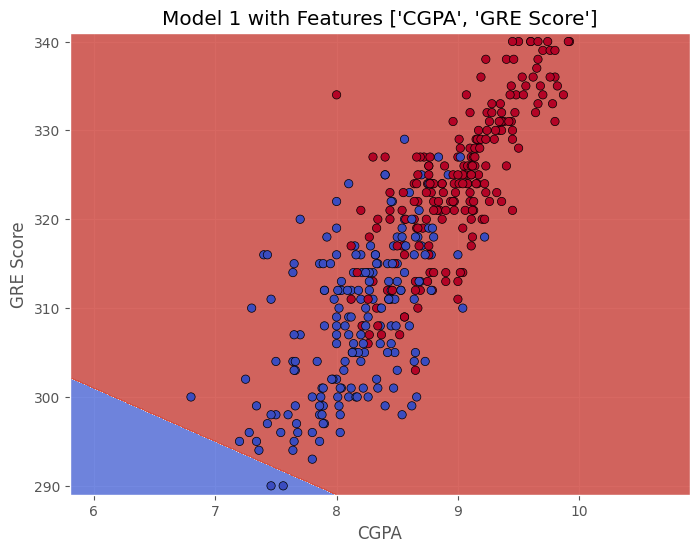

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

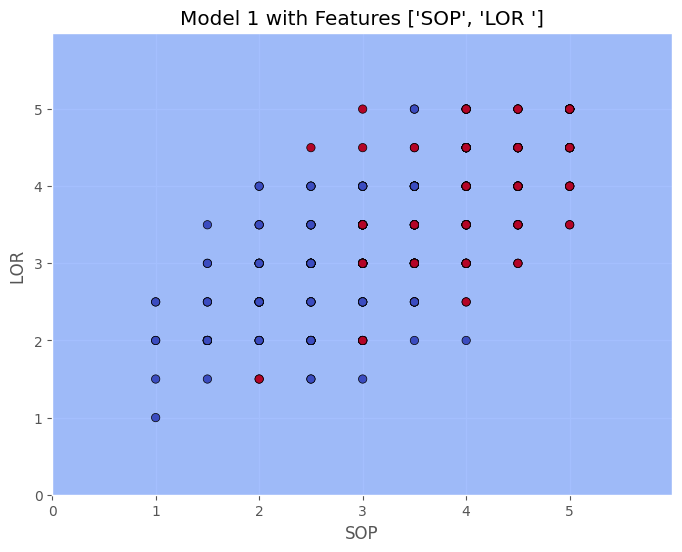

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

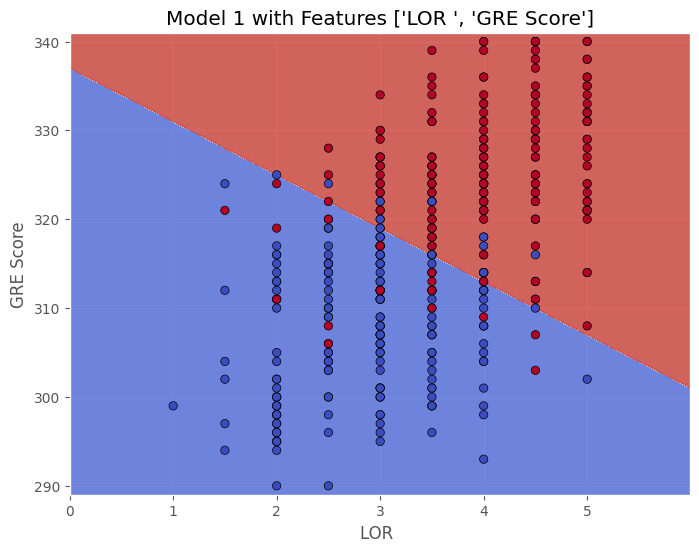

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

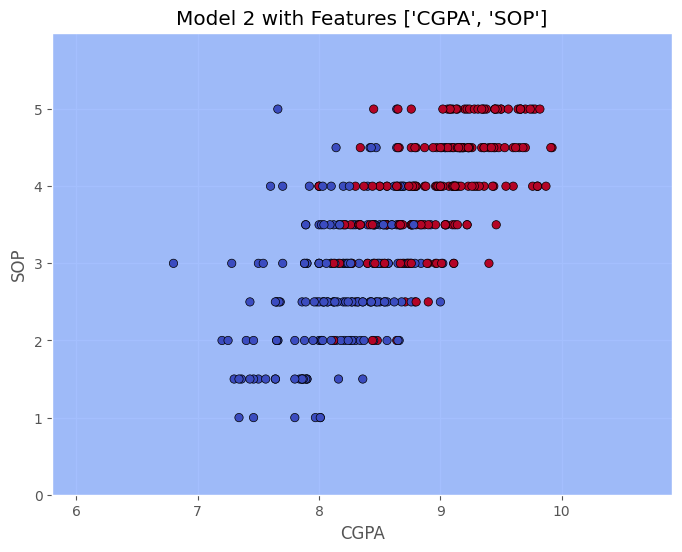

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

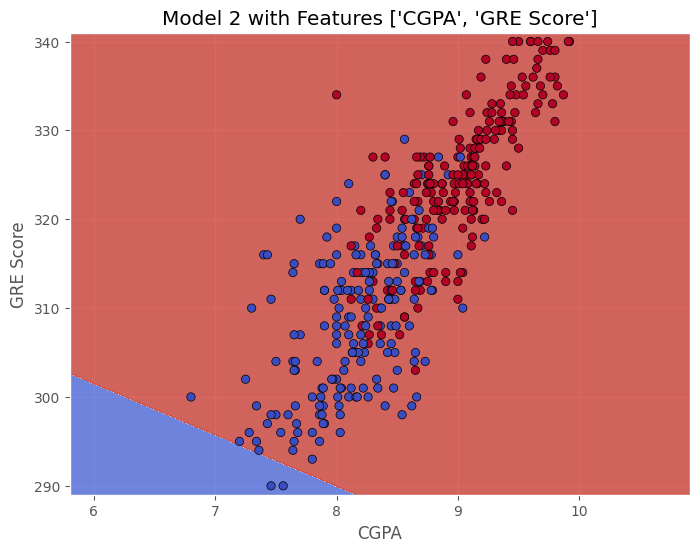

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

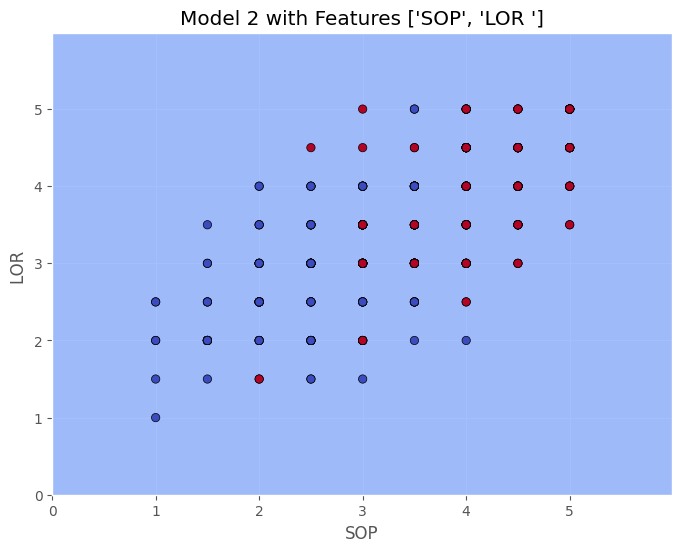

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

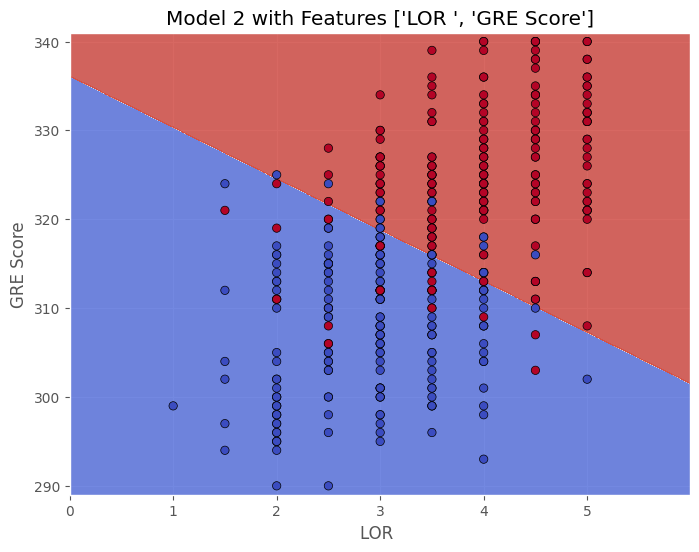

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

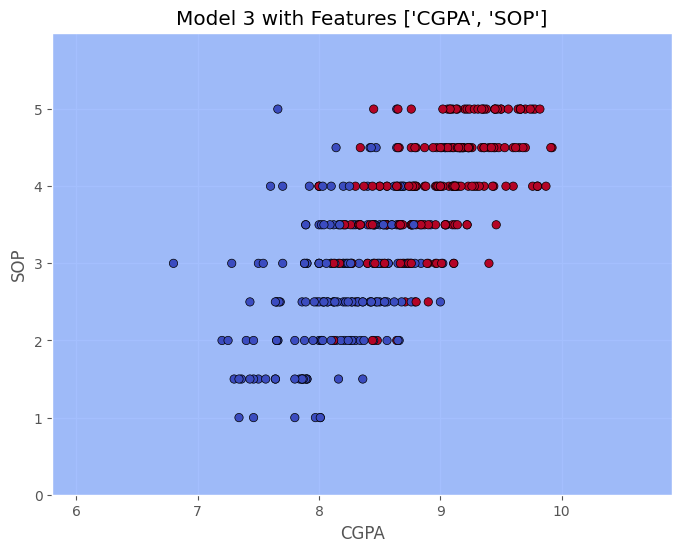

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

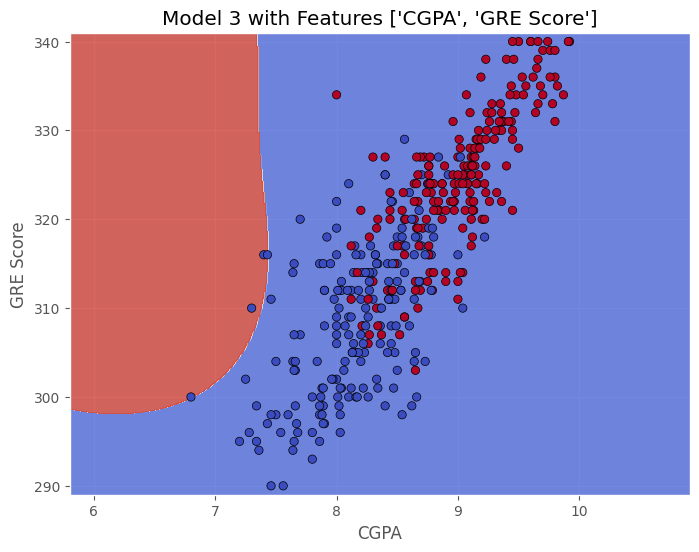

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

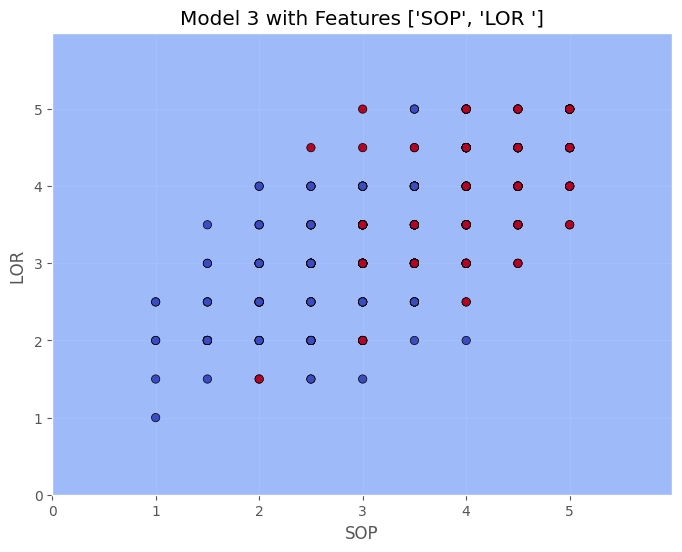

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

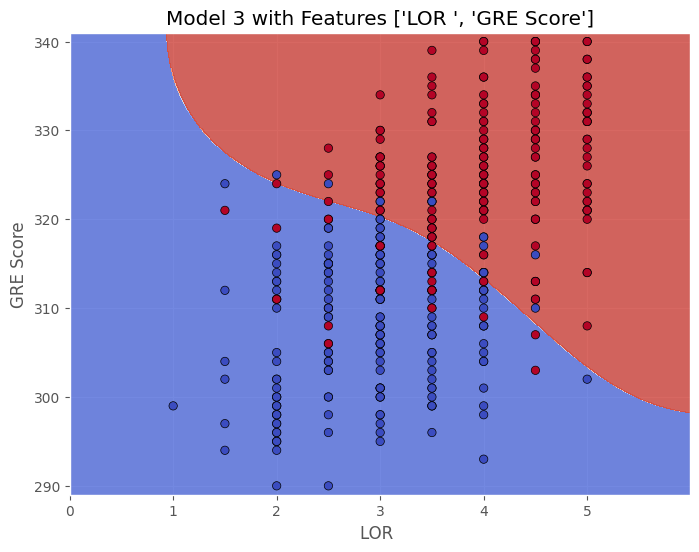

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

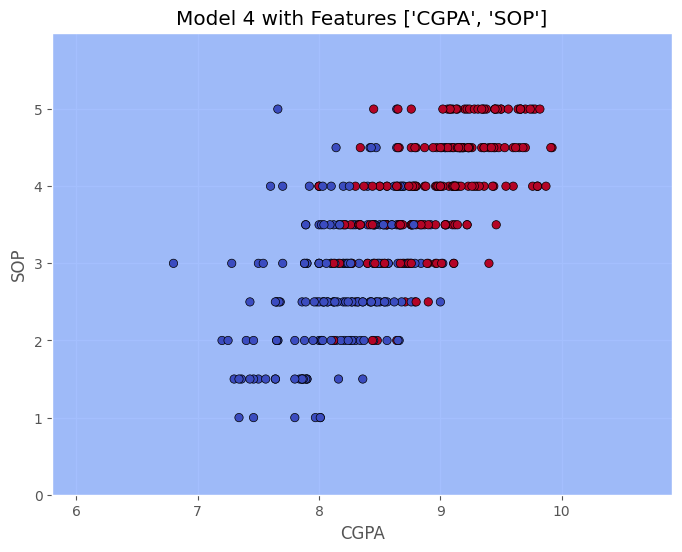

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

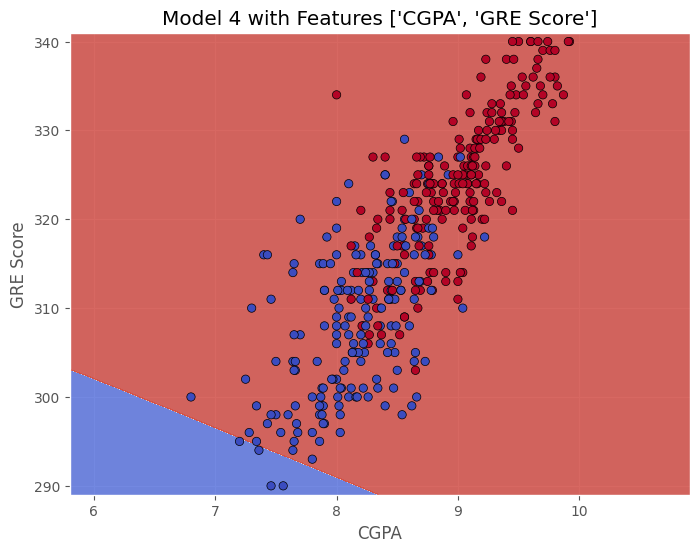

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

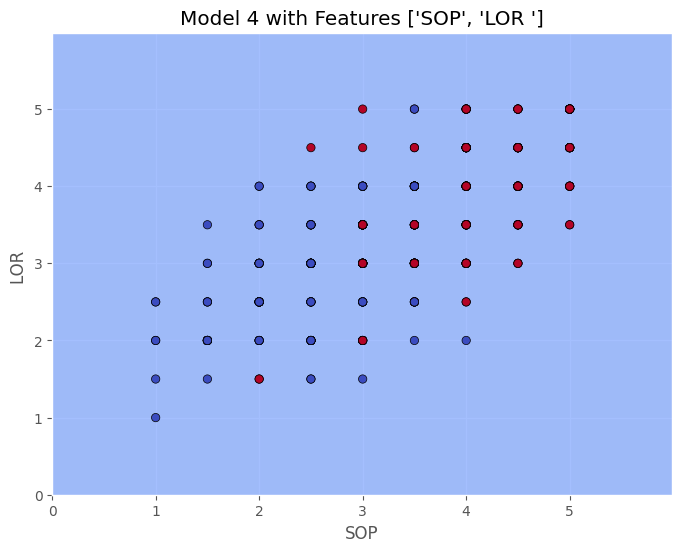

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

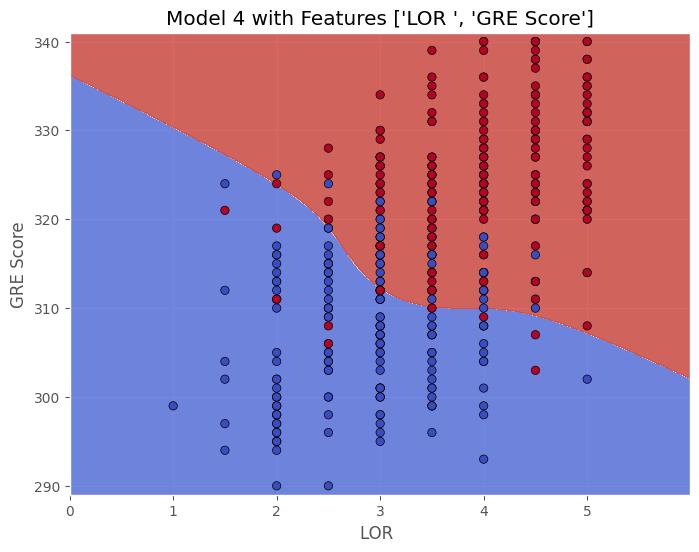

In [44]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    plt.figure(figsize=(8, 6))
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

# List of SVM models
svm_models = [svm_linear, linear_svc, svm_rbf, svm_poly]

# List of feature combinations
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

# Visualize decision boundaries for each model and feature combination
for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]

        plt.figure(figsize=(8, 6))
        plot_decision_boundary(model, X, y, f"Model {i+1} with Features {features}")


## Part D

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

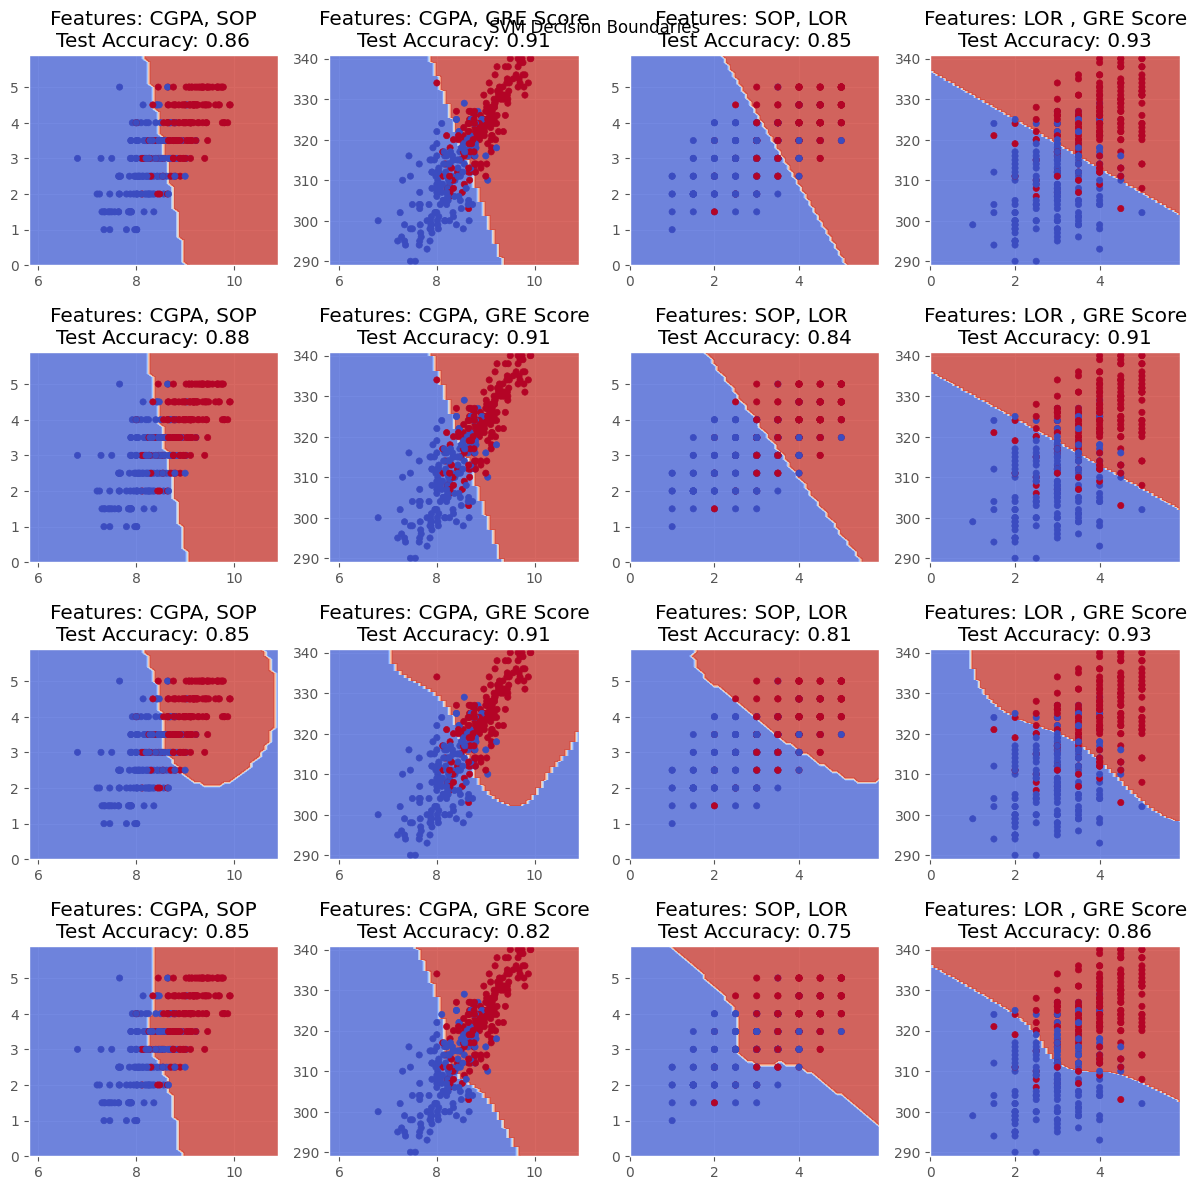

In [45]:
# Initialize subplots for visualization
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("SVM Decision Boundaries")

for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_subset = X_train
        X_test_subset = X_test

        # # Standardize the data for SVM
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train_subset)
        # X_test_scaled = scaler.transform(X_test_subset)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model on the test set
        test_accuracy = model.score(X_test, y_test)

        # Visualize the decision boundary
        ax = axes[i, j]
        x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
        y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20)
        ax.set_title(f"Features: {', '.join(features)}\nTest Accuracy: {test_accuracy:.2f}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## Part E

## Part F